In [16]:
import sys, os
sys.path.append('./src')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import pandas as pd 
import numpy as np
import random 
from sklearn.preprocessing import StandardScaler
from umap import UMAP

from model import Encoder, Decoder, OutputLayer
from loss_function import ZINB, maximum_mean_discrepancy, TripletLoss, CircleLoss
from train import train_epoch_mmd

from dataset import dataset
from scipy import sparse

import utils
import model
import train
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.preprocessing import LabelEncoder
from metrics import *
import anndata as ad

In [2]:
le = LabelEncoder()

## New version for 8 batches
There seems to be some issue with the original implementation, so I re-write the training and dataset generation code. The clusters are better separated this time. Please check the new code when you have time.

-Ziqi

In [3]:
class dataset(Dataset):

    def __init__(self, counts, anno, time_point, batch_id):

        assert not len(counts) == 0, "Count is empty"
        # normalize the count
        self.libsizes = np.tile(np.sum(counts, axis = 1, keepdims = True), (1, counts.shape[1]))
        self.counts_norm = counts/self.libsizes * 100
        self.counts_norm = np.log1p(self.counts_norm)
        self.counts = torch.FloatTensor(counts)

        # further standardize the count
        self.counts_stand = torch.FloatTensor(StandardScaler().fit_transform(self.counts_norm))
        self.anno = torch.Tensor(anno)
        self.libsizes = torch.FloatTensor(self.libsizes)
        self.time_point = torch.Tensor(time_point)
        self.batch_id = torch.Tensor(batch_id)

    def __len__(self):
        return self.counts.shape[0]
    
    def __getitem__(self, idx):
        # data original data, index the index of cell, label, corresponding labels, batch, corresponding batch number
        if self.anno is not None:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx] , "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "anno": self.anno[idx], "libsize": self.libsizes[idx]}
        else:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx] ,"count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "libsize": self.libsizes[idx]}
        return sample


In [4]:
dir = './data/scp_gex_matrix/sepsis_test_7533/'
# 0, 1, 2, 3, 4, 5, 6,
names = ['Control', 'Leuk-UTI', 'Int-URO', 'URO', 'Bac-SEP', 'ICU-SEP', 'ICU-NoSEP']
batchsize = 32
nbatches = len(names)*2
ngenes = 7533
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)

sc_datasets = []
train_loaders = []
test_loaders = []
for n in np.arange(1,3):
    for name in names:
        counts_rna = np.array(sparse.load_npz(os.path.join(dir, 'sampled_mtx_{}_batch_{}.npz'.format(name, n))).todense())
        anno = pd.read_csv(os.path.join(dir, 'sampled_meta_{}_batch_{}.csv'.format(name, n)))["Cell_Type"]
        anno = le.fit_transform(anno)
#         batch_id = [names.index(name) + (n-1)*7]
        sc_dataset = dataset(counts = counts_rna, anno = anno, time_point=[names.index(name)] * len(anno), 
                             batch_id = [names.index(name) + (n-1)*7] * len(anno))
        sc_datasets.append(sc_dataset)
        train_loaders.append(DataLoader(sc_dataset, batch_size = batchsize, shuffle = True))
        test_loaders.append(DataLoader(sc_dataset, batch_size = len(sc_dataset), shuffle = False))

In [5]:
le.fit_transform(['T', 'Mono', 'NK', 'B', 'DC'])

array([4, 2, 3, 0, 1])

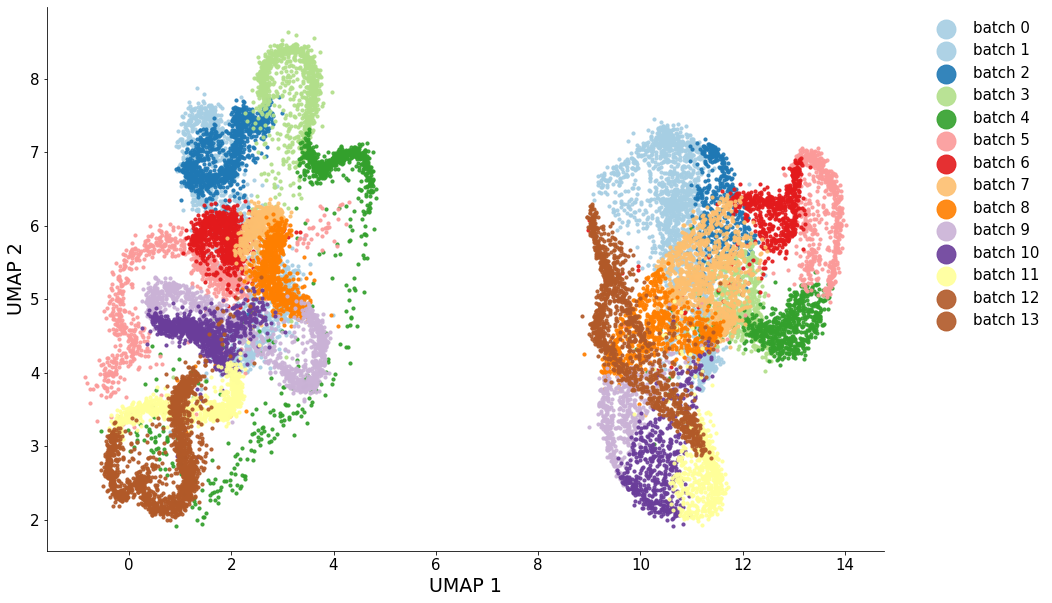

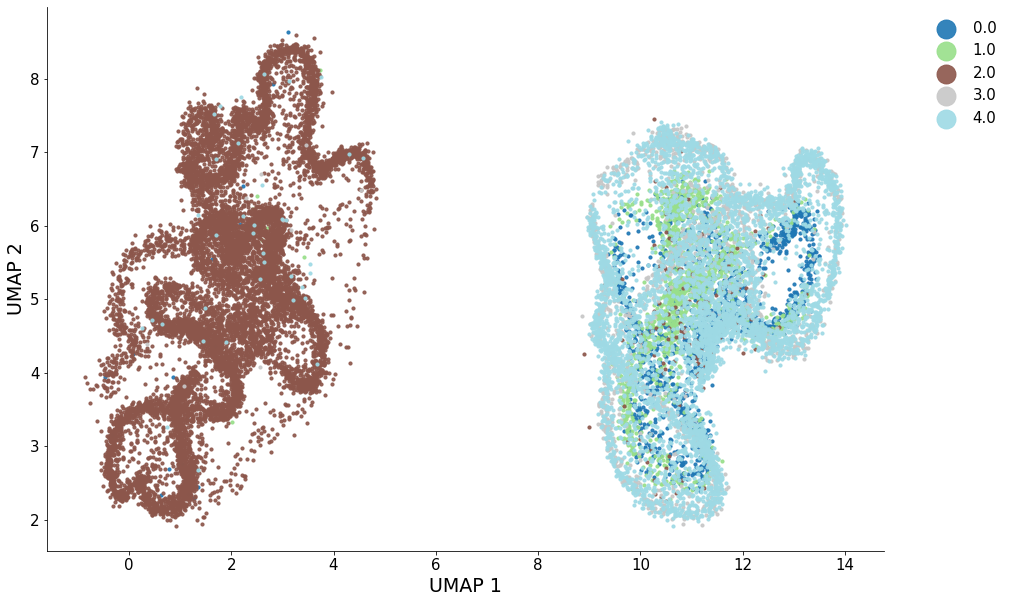

In [6]:
# before integration
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.1, random_state = 0) 
counts_norms = []
annos = []
batch_ids = []
for batch in range(nbatches):
    counts_norms.append(sc_datasets[batch].counts_norm)
    annos.append(sc_datasets[batch].anno)
    batch_ids.append(sc_datasets[batch].batch_id)

x_umap = umap_op.fit_transform(np.concatenate(counts_norms, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

save_file = None

utils.plot_latent(x_umaps, annos = annos, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


In [7]:
import importlib
importlib.reload(train)

<module 'train' from './src/train.py'>

In [8]:
def train_epoch_mmd(model_dict, train_data_loaders, test_data_loaders, optimizer, 
                    n_epoches = 100, interval = 10, lamb_mmd = 1e-3, lamb_pi = 1e-5, 
                    use_zinb = True, contr_factor=1e-1, contr_loss=None, cont=False, time_dim = 5):
#     time_dim = dim_split[0]
#     type_dim = dim_split[0] + dim_split[1]
    
    loss_zinb_tests = []
    loss_mmd_tests = []
    loss_tests = []
    contr_loss_tests = []
    triplet_loss = TripletLoss(margin=0.3)
    contr_feature = 'time_point'
    for epoch in range(n_epoches + 1):
        # train the model
        for data_batch in zip(*train_data_loaders):
            loss_mmd = 0
            loss_zinb = 0
            loss_contr = 0
            loss_contr_type = 0
            for idx, x in enumerate(data_batch):
                z = model_dict["encoder"](x["count_stand"].to(device))
                mu, pi, theta = model_dict["decoder"](z)
                
                z = model_dict["encoder"](x["count_stand"].to(device))
                mu, pi, theta = model_dict["decoder"](z)
                # negative log likelihood
                if use_zinb:
                    loss_zinb += ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(device), ridge_lambda = lamb_pi).loss(y_true = x["count"].to(device), y_pred = mu)
                else:
                    # if not use ZINB, then assume the data is Gaussian instead
                    loss_zinb += (mu * x["libsize"].to(device) - x["count"].to(device)).pow(2).sum()
                    
                # if there are more than 1 batch, calculate mmd loss between current batch and previous batch
                if (len(data_batch) >= 2) & (idx > 0):
                    loss_mmd += maximum_mean_discrepancy(z_pre[:, time_dim:], z[:, time_dim:])
                    if contr_loss:
                        loss_contr += contr_loss(torch.cat((z[:, :time_dim].to(device), z_pre[:, :time_dim].to(device)), dim=0), torch.cat((x[contr_feature].to(device), label_pre.to(device))))
#                         loss_contr_type += triplet_loss(torch.cat((z[:, time_dim:].to(device), z_pre[:, time_dim:].to(device)), dim=0), torch.cat((x['anno'].to(device), type_pre.to(device))))
                    else:
                        loss_contr += torch.FloatTensor([0]).to(device)
                else:
                    loss_mmd += torch.FloatTensor([0]).to(device)

                z_pre = z.clone()
                label_pre = (x[contr_feature]).clone()
                type_pre = (x['anno']).clone()

            loss = loss_zinb + lamb_mmd * loss_mmd + loss_contr * contr_factor
#             loss = loss_zinb + lamb_mmd * loss_mmd + loss_contr * contr_factor + loss_contr_type * 0.05
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # test the model
        if epoch % interval == 0:
            loss_mmd_test = 0
            loss_zinb_test = 0 
            loss_contr_test = 0
            loss_contr_type_test = 0
            for data_batch in zip(*test_data_loaders):
                with torch.no_grad():
                    for idx, x in enumerate(data_batch):
                        z = model_dict["encoder"](x["count_stand"].to(device))
                        mu, pi, theta = model_dict["decoder"](z)
                        if use_zinb:
                            loss_zinb_test += ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(device), ridge_lambda = lamb_pi).loss(y_true = x['count'].to(device), y_pred = mu)
                        else:
                            loss_zinb_test += (mu * x["libsize"].to(device) - x["count"].to(device)).pow(2).sum()

                        if (len(data_batch) >= 2) & (idx > 0):
                            loss_mmd_test += maximum_mean_discrepancy(z_pre[:, time_dim:], z[:, time_dim:])

                            if contr_loss:
                                loss_contr_test += contr_loss(torch.cat((z[:, :time_dim], z_pre[:, :time_dim]), dim=0), torch.cat((x[contr_feature], label_pre)))
#                                 loss_contr_type_test += triplet_loss(torch.cat((z[:, time_dim:], z_pre[:, time_dim:]), dim=0), torch.cat((x['anno'], type_pre)))
                            else: 
                                loss_contr_test = 0
                        else:
                            loss_mmd_test += torch.FloatTensor([0]).to(device)
                        z_pre = z.clone()
                        label_pre = torch.Tensor(x[contr_feature]).clone()
                        type_pre = torch.Tensor(x['anno']).clone()
                        loss_test = loss_zinb_test + lamb_mmd * loss_mmd_test + loss_contr_test * contr_factor
#                         loss_test = loss_zinb_test + lamb_mmd * loss_mmd_test + loss_contr_test * contr_factor + loss_contr_type_test * 0.05

            info = [
                'mmd loss: {:.3f}'.format(loss_mmd_test.item()),
                'ZINB loss: {:.3f}'.format(loss_zinb_test.item()),
                'overall loss: {:.3f}'.format(loss_test.item()),
                'contrastive loss: {:.3f}'.format(loss_contr_test.item()),
            ]

            print("epoch: ", epoch)
            for i in info:
                print("\t", i)
            contr_loss_tests.append(loss_contr_test.item())
            loss_mmd_tests.append(loss_mmd_test.item())
            loss_zinb_tests.append(loss_zinb_test.item())
            loss_tests.append(loss_test.item())
    return loss_tests, loss_mmd_tests, loss_zinb_tests, contr_loss_tests

In [9]:
# initialize the model
ldim = 32
lr = 5e-4
model_dict = {}
model_dict["encoder"] = model.Encoder(features = [ngenes, 256, 32, ldim], dropout_rate = 0, negative_slope = 0.2).to(device)
model_dict["decoder"] = model.Decoder(features = [ldim, 32, 256, ngenes], dropout_rate = 0, negative_slope = 0.2).to(device)
# initialize the optimizer
param_to_optimize = [
    {'params': model_dict["encoder"].parameters()},
    {'params': model_dict["decoder"].parameters()}
]

optim_ae = torch.optim.Adam(param_to_optimize, lr=lr)

# use Circle loss to distinguish different time points
contrastive_loss = CircleLoss(m=0.25, gamma= 0.01)
# contrastive_loss = TripletLoss(margin=0.3)
contr_factor = 1e-1
n_epoches = 30
time_dim = 15
losses = train_epoch_mmd(model_dict, train_data_loaders = train_loaders, test_data_loaders = test_loaders, 
                      optimizer = optim_ae, n_epoches = n_epoches, interval = 10, lamb_mmd = 5e-2, 
                      lamb_pi = 1e-5, use_zinb = True, contr_factor=contr_factor,contr_loss=contrastive_loss, 
                        time_dim = time_dim)

epoch:  0
	 mmd loss: 0.434
	 ZINB loss: 10.165
	 overall loss: 48.237
	 contrastive loss: 380.503
epoch:  10
	 mmd loss: 0.135
	 ZINB loss: 6.093
	 overall loss: 44.136
	 contrastive loss: 380.362
epoch:  20
	 mmd loss: 0.106
	 ZINB loss: 5.803
	 overall loss: 43.843
	 contrastive loss: 380.347
epoch:  30
	 mmd loss: 0.099
	 ZINB loss: 5.736
	 overall loss: 43.774
	 contrastive loss: 380.337


## Metrics for Benchmarking
**I've implemented: 
        NMI, 
        ARI, 
        graph_connectivity,
to help tune model, mostly referring to CLEAR model and paper "Benchmarking atlas-level data integration in single-cell genomics"** - Xinye


NMI Score :  0.5818579183969503 
 ARI Score:  0.4818057717806242 
 Cluster Number: 5
Computing kBET
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 4
kBET score: 0.12241475957165071


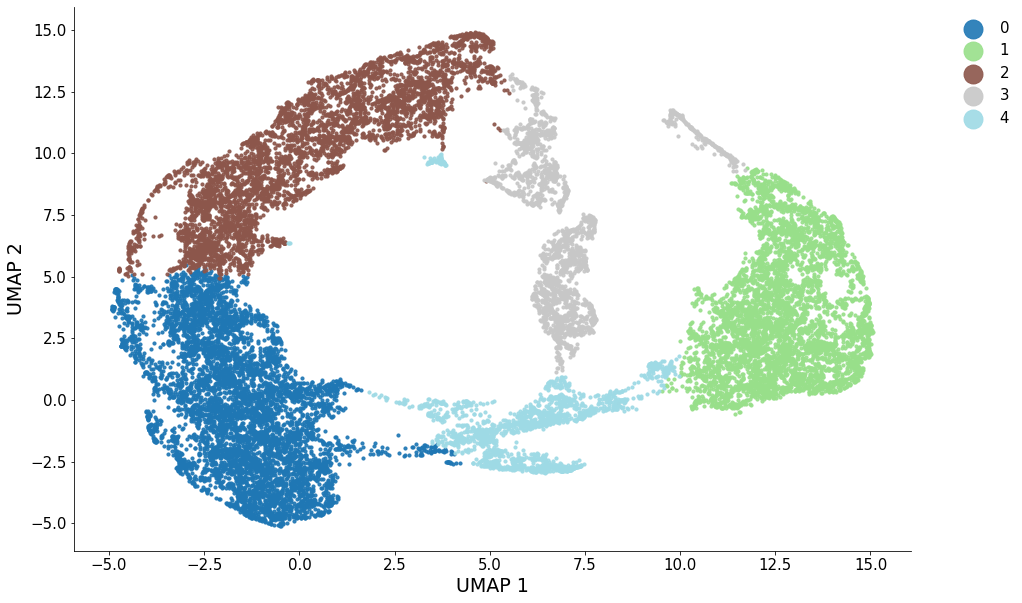

In [20]:
zs = []
for data_batch in zip(*test_loaders):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            zs.append(z.cpu().detach().numpy())

obs = pd.DataFrame()
data = ad.AnnData(np.concatenate(zs))
data.obs['label'] = pd.Series([str(i) for i in np.concatenate(annos)], dtype="category").values
data.obs['batch'] = pd.Series([str(i) for i in np.concatenate(batch_ids)], dtype="category").values

# ari and nmi
ari_nmi(data, annos, resolution=0.08, show_fig=True)
print('Computing kBET')
print('kBET score:', kBET(data, 'batch', 'label', embed=None))
# print("/nGraph Connectivity Score:", graph_connectivity(data, 'label'))

## Visualize embedding without time dimentions

In [ ]:
zs = []
import time
batch_id_1, batch_id_2 = 0,7
test_loaders_sub = [test_loaders[batch_id_1], test_loaders[batch_id_2]]
nbatches_sub = len(test_loaders_sub)
for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            zs.append(z.cpu().detach().numpy())

annos_sub = [annos[batch_id_1], annos[batch_id_2]]

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0)[:, time_dim:])
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'NO_TIME_DIMS_15_Circle_m_0.1_gamma_0.01'
path = '/net/csefiles/xzhanglab/xzhao429/Projects/AntennaVAE/sepsis_results/report_7533/separate_dim/Circle_15/'
save_file_id = path + 'id_contr_{}_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, contr_factor,batch_id_1, batch_id_2, n_epoches)
save_file_type = path + 'type_contr_{}_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, contr_factor,batch_id_1, batch_id_2,n_epoches )
save_file = None
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Loss plot
The change of loss function with iterations

In [ ]:

loss_total = losses[0]
loss_mmd = losses[1]
loss_zinb = losses[2]
loss_triplet = losses[3]

iterations = np.arange(1, len(loss_mmd) + 1)
fig = plt.figure(figsize = (40, 10))
ax = fig.add_subplot()
ax.plot(iterations, loss_total, "-*", label = "Total")
ax.plot(iterations, loss_mmd, "-*", label = "MMD")
ax.plot(iterations, loss_zinb, "-*",label = "ZINB")
# ax.plot(iterations, loss_triplet.cpu(), "-*",label = "TRIPLET")
ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
ax.set_yscale("log")
for i,j in zip(iterations,loss_zinb):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_mmd):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_total):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_triplet):
    ax.annotate("{:.3f}".format(j),xy=(i,j)) 

## Visualization of batch 5 and 6
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


In [ ]:
zs = []
import time
# Each time point has to batch id: 1 and 2, so k and k+7 should match since they are from the same time point
# for i in range(6):
#     for j in range(i+1, 7):
batch_id_1, batch_id_2 = 0,6
test_loaders_sub = [test_loaders[batch_id_1], test_loaders[batch_id_2]]
nbatches_sub = len(test_loaders_sub)
for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            zs.append(z.cpu().detach().numpy())

annos_sub = [annos[batch_id_1], annos[batch_id_2]]

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
comment = 'WITH_TIME_DIMS_15_Circle_m_0.1_gamma_0.01'
path = '/net/csefiles/xzhanglab/xzhao429/Projects/AntennaVAE/sepsis_results/report_7533/separate_dim/Circle_15/'
save_file_id = path + 'id_contr_{}_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, contr_factor,batch_id_1, batch_id_2, n_epoches)
save_file_type = path + 'type_contr_{}_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, contr_factor,batch_id_1, batch_id_2,n_epoches )
save_file = None
utils.plot_latent(x_umaps, annos = annos_sub, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos_sub, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualization of all 8 batches
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


In [ ]:
zs = []
for data_batch in zip(*test_loaders):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            zs.append(z.cpu().detach().numpy())
            
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
comment = 'ALL_WITH_TIME_DIMS_15_Circle_m_0.1_gamma_0.01'
path = '/net/csefiles/xzhanglab/xzhao429/Projects/AntennaVAE/sepsis_results/report_7533/separate_dim/Circle_15/'
save_file_id = path + 'id_sepsis_{}_contr_{}_epoch_{}.png'.format(comment, contr_factor, n_epoches)
save_file_type = path + 'type_sepsis_{}_contr_{}_epoch_{}.png'.format(comment, contr_factor,n_epoches)

utils.plot_latent(x_umaps, annos = annos, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")
